# Input

Time series $Z$ mixed with noise
$$Y = Z + E,$$
where $E$ is a whitenoise
$$
cov(E_i, E_j) =
\begin{cases}
\sigma_e^2,& i = j \\
0,&          i \neq j
\end{cases} 
$$

$Z$ depends on $X_i, i = 1..6$ time series.

# Task
- Find and remove anomalies in $Y$
- Create regression model $\mu$: $Z = \mu\left( X \right)$
- Find prediction for three more values of $Z$ by
  - extrapolation of $Z$
  - model $\mu\left( X \right)$ and prediction of $X$
- Estimate prediction errors
- Choose the best prediction

# Tools
- [Exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing)
- [Autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 15.0)

In [2]:
from matplotlib import rc
rc('font', size=18)

In [3]:
from numpy import loadtxt, arange, log, delete, array
from scipy.stats import f
from scipy.stats.mstats import normaltest
from pandas.stats.moments import ewma
from pandas import Series

In [4]:
dataset = loadtxt('data.csv', skiprows=1, delimiter=',')
t = arange(dataset.shape[0])
y = dataset[:, 0]
xs = dataset[:, 1:].transpose()

In [5]:
F_TAIL_CRITICAL = 0.1

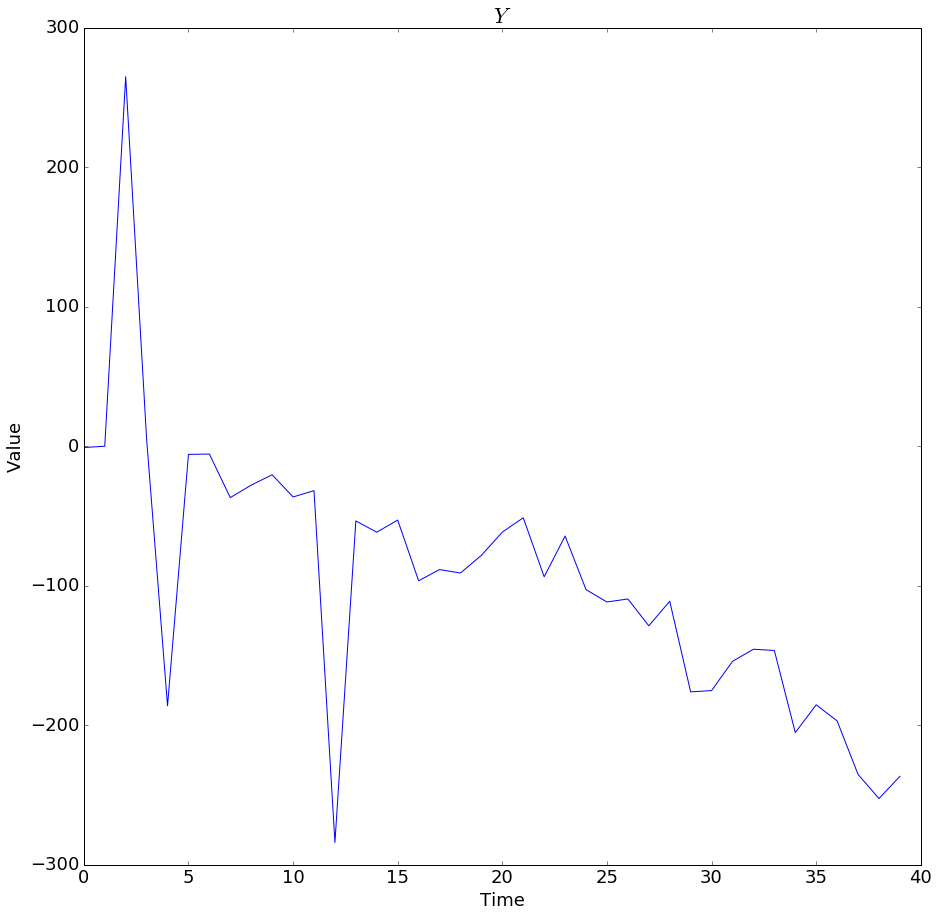

In [6]:
plt.plot(t, y)
plt.title('$Y$')
plt.ylabel('Value')
plt.xlabel('Time')
plt.show()

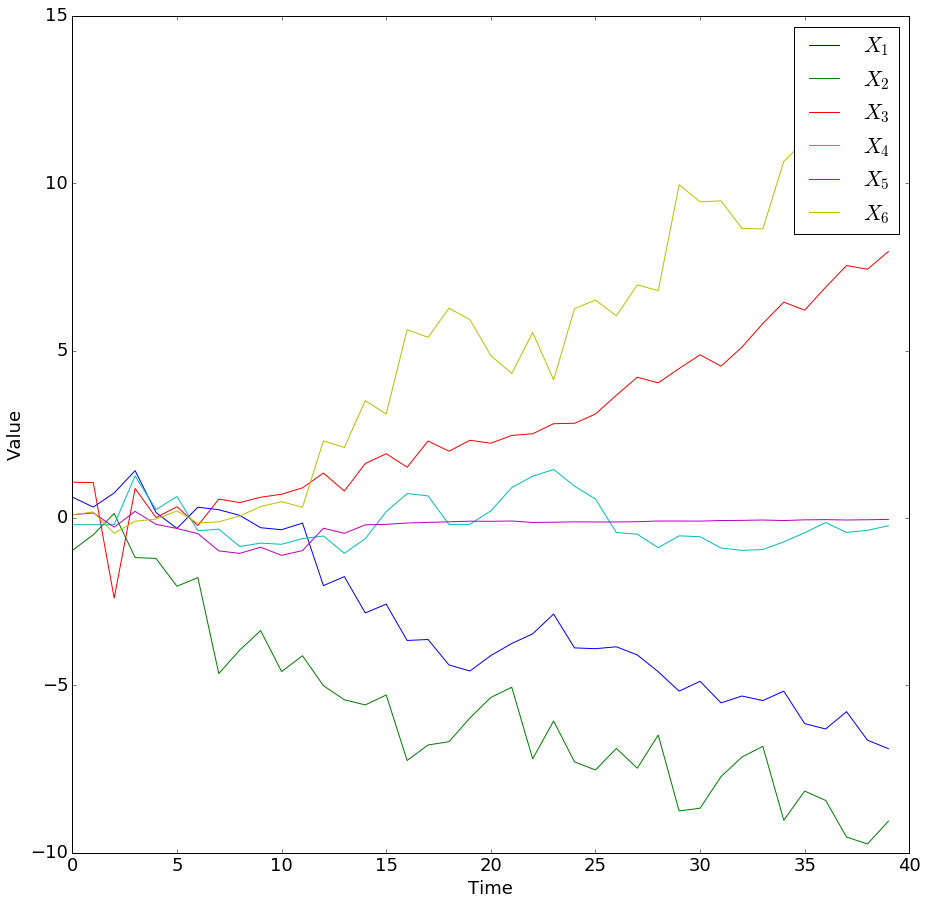

In [7]:
for i, x in enumerate(xs):
    plt.plot(t, x, label='$X_%d$'%(i+1))

plt.ylabel('Value')
plt.xlabel('Time')
plt.legend()
plt.show()

# Smoothing

## Initial smoothing

Exponential moving average with window size $6$ will be used

In [8]:
def data_smoother(data, span):
    smoothed = ewma(data, span=span)
    errors = data - smoothed
    return smoothed# + errors.mean()

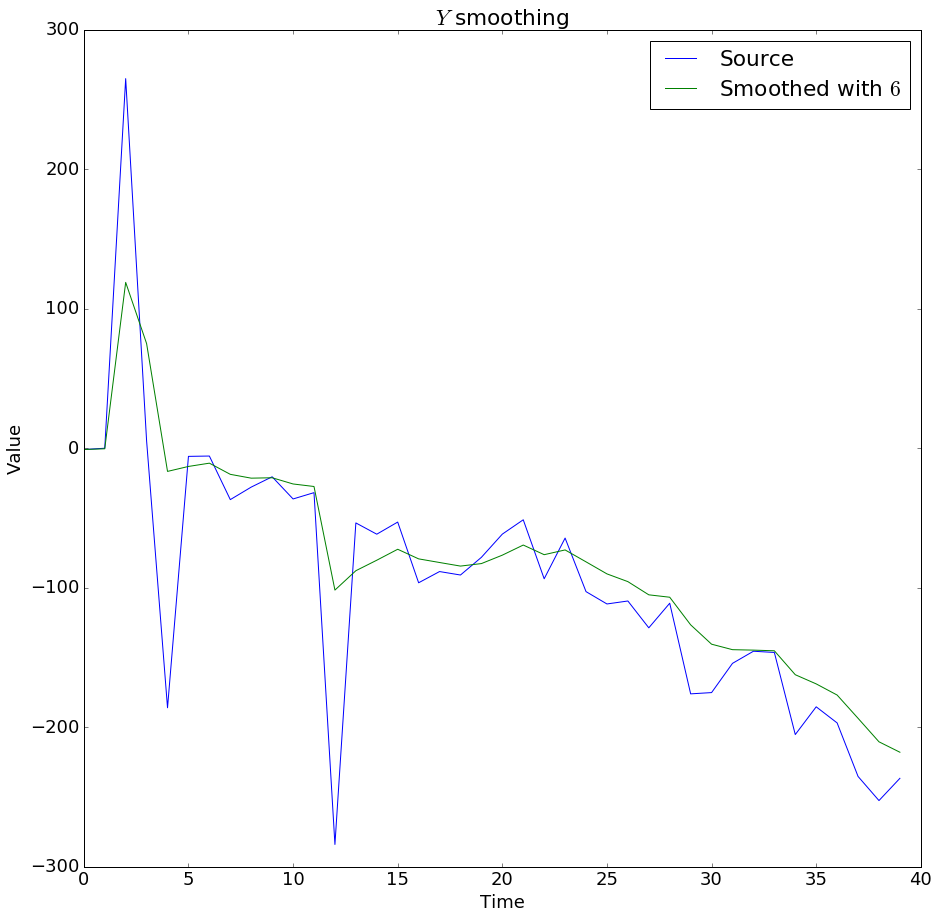

In [9]:
span = 6
smoothed_y = data_smoother(y, span=span)

plt.plot(t, y, label='Source')
plt.plot(t, smoothed_y, label='Smoothed with $%d$'%span)

plt.title('$Y$ smoothing')
plt.ylabel('Value')
plt.xlabel('Time')

plt.legend()

plt.show()

## Find anomalies

Anomaly points are the ones which affect smoothing.

We can find them as points which increase standard deviation of smoothing errors a lot.

Given an anomaly point $t$ we can build new time series $Y_{fixed}\left( t \right)$ without this point
and check whether this point is really anomaly
$$
V\left( t \right)
= \frac{Var\left( Y - Y^{smoothed} \right)}
       {Var\left( Y_{fixed}\left(t\right) - Y_{fixed}^{smoothed}\left(t\right) \right)}
> V_{critical}
$$

It's an [F-test](https://en.wikipedia.org/wiki/F-test) and we can do it in following way
$$
\max\limits_{t}{F_{F, T, T-1}\left( V\left( t \right) \right)} > F_{F, T, T-1}^{critical}
\Longrightarrow
t_{anomaly} = \max\limits_{t}{F_{F, T, T-1}\left( V\left( t \right) \right)}.
$$
because errors have normal distribution by initial conditions.

In [10]:
def get_fixed_std(data_series, position, span):
    data_series = delete(data_series, position)
    return (data_series - data_smoother(data_series, span=span)).std()

In [11]:
def get_f_test_values(data_series, span):
    smoothed_series = data_smoother(data_series, span=span)
    anomalies_stds = [get_fixed_std(data_series, i, span) for i in range(data_series.size)]
    anomalies = array([(data_series - smoothed_series).std() / std for std in anomalies_stds])**2
    return anomalies

In [12]:
def get_f_weights(anomalies):
    return array([1 - f.cdf(anomaly, anomalies.size - 1, anomalies.size - 2) for anomaly in anomalies])

In [13]:
def display_variances_without_anomalies(data, anomaly_points=()):
    time = t
    for anomaly_point in anomaly_points:
        data = delete(data, anomaly_point)
        time = delete(time, time.size - 1)

    anomalies = get_f_test_values(data, span)
    f_test = get_f_weights(anomalies)
    
    plt.plot(time, f_test)
    plt.suptitle('F-test tail weights', fontweight='bold')
    if len(anomaly_points) > 0:
        plt.title('Removed anomalies ' + ', '.join(['$%d$'%p for p in anomaly_points]))
    plt.xlabel('Anomaly point')
    plt.ylabel('Tail weight')
    plt.show()
    return f_test.min(), f_test.argmin()

Let's take a look on variances of fixed time series, which don't contain specific points

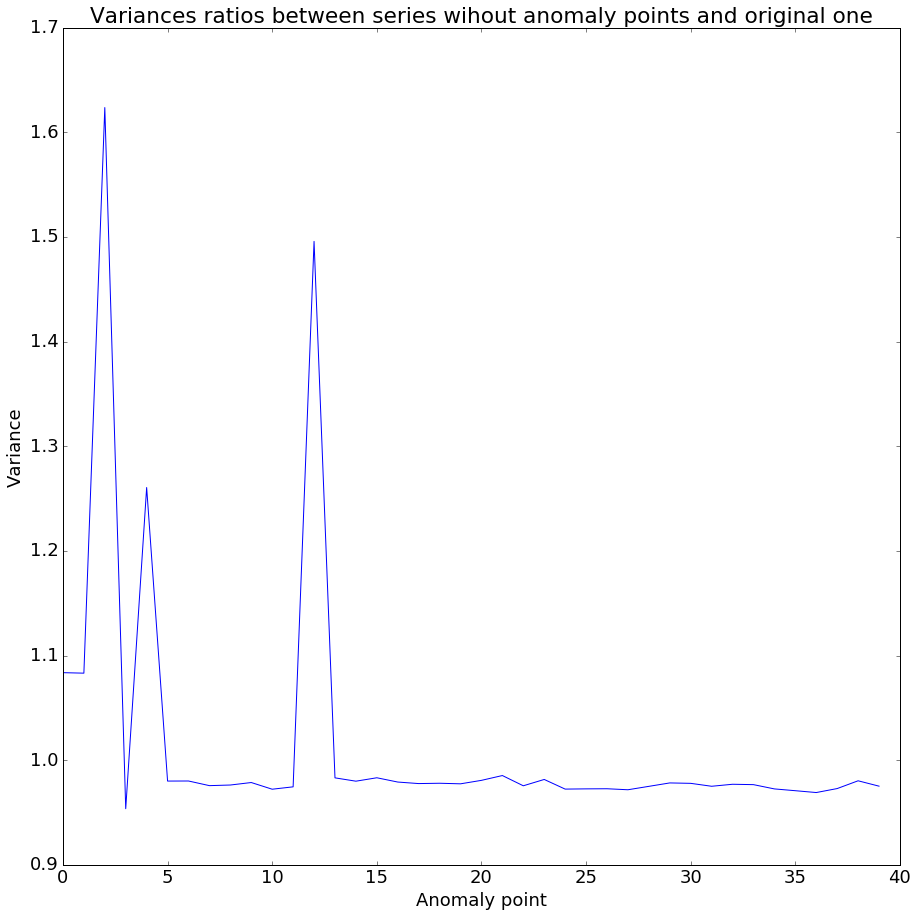

In [14]:
anomalies = get_f_test_values(y, span)
f_test = get_f_weights(anomalies)

plt.plot(t, anomalies)
plt.title('Variances ratios between series wihout anomaly points and original one')
plt.xlabel('Anomaly point')
plt.ylabel('Variance')
plt.show()

Plot which contains weight of Fisher distribution tails for each fixed time series

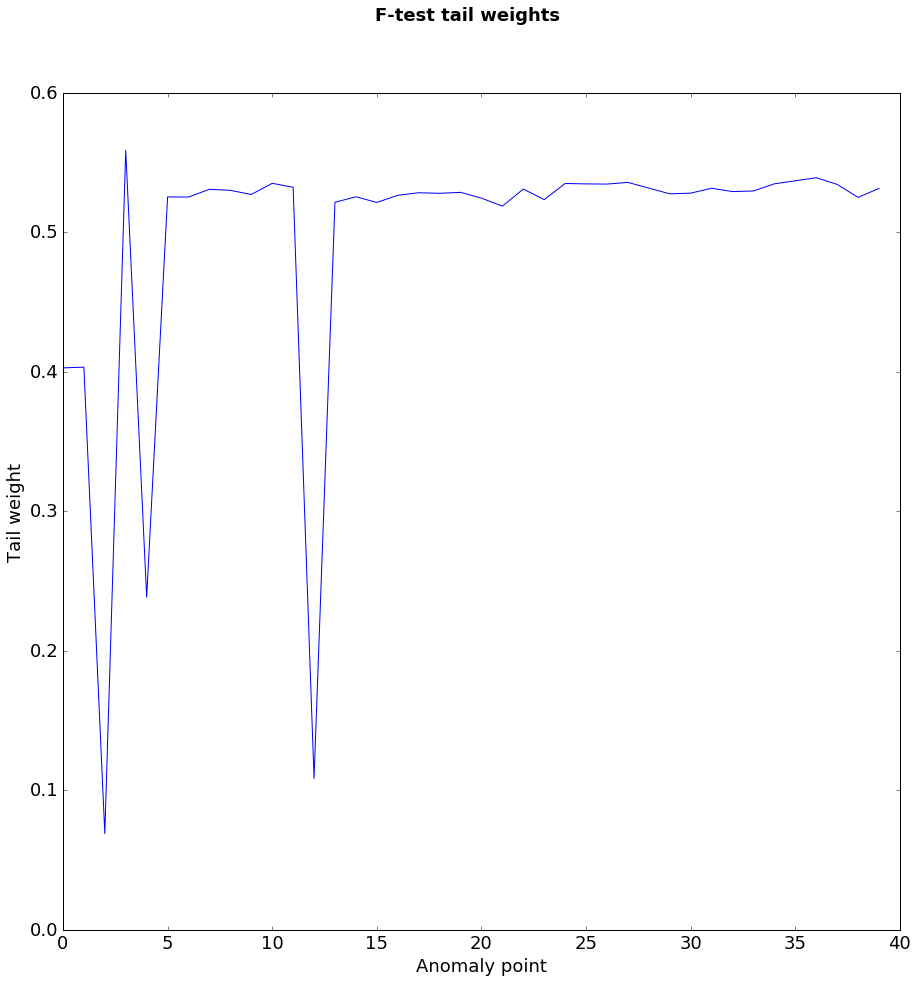

In [15]:
min_f_tail, suspicious_point = display_variances_without_anomalies(y)

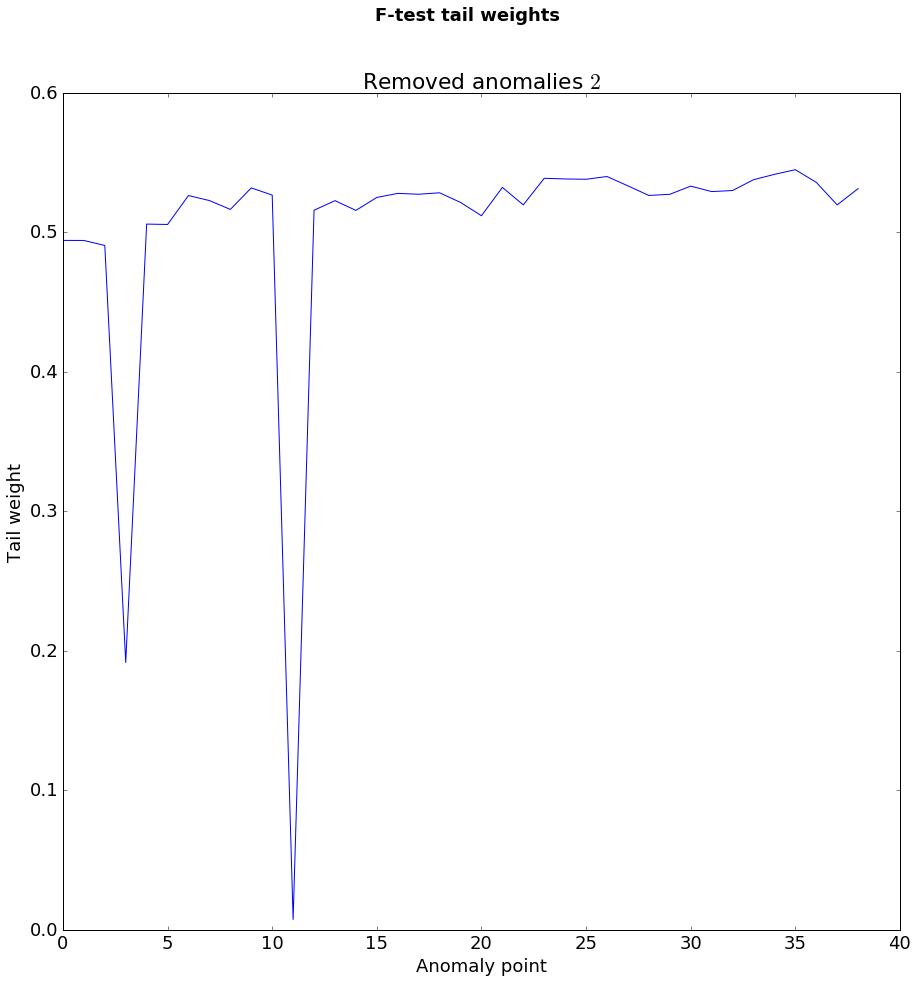

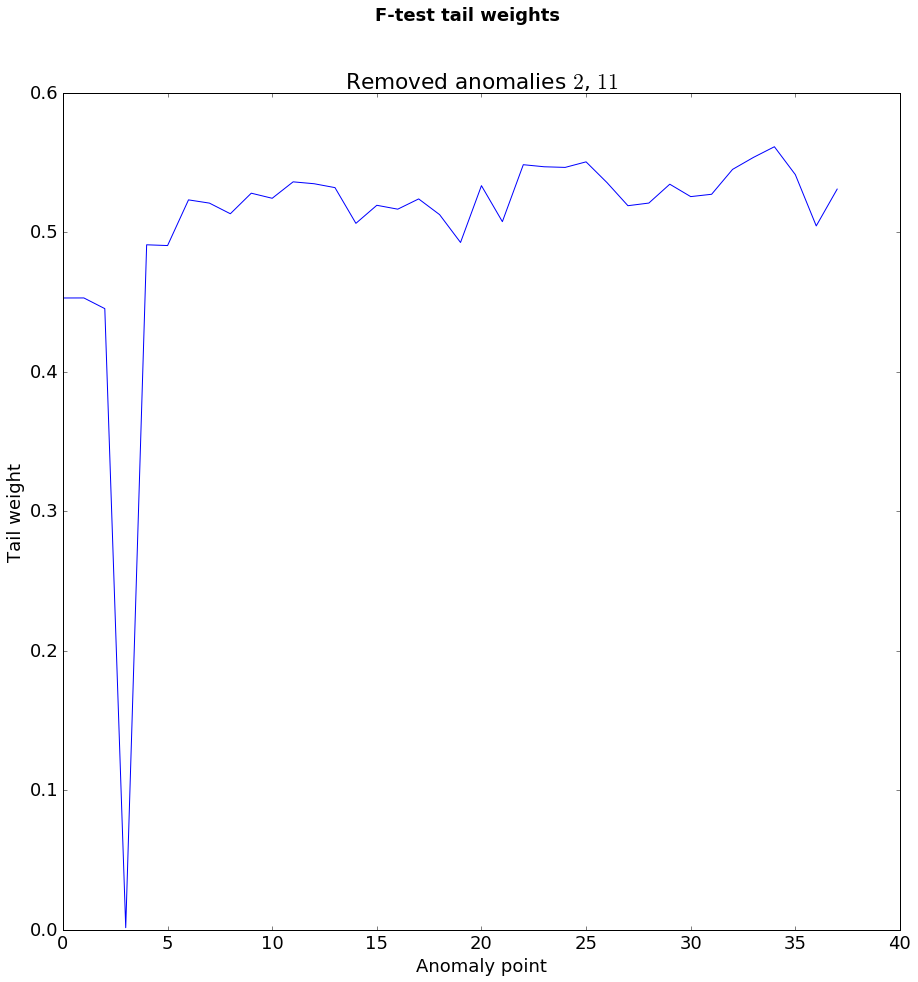

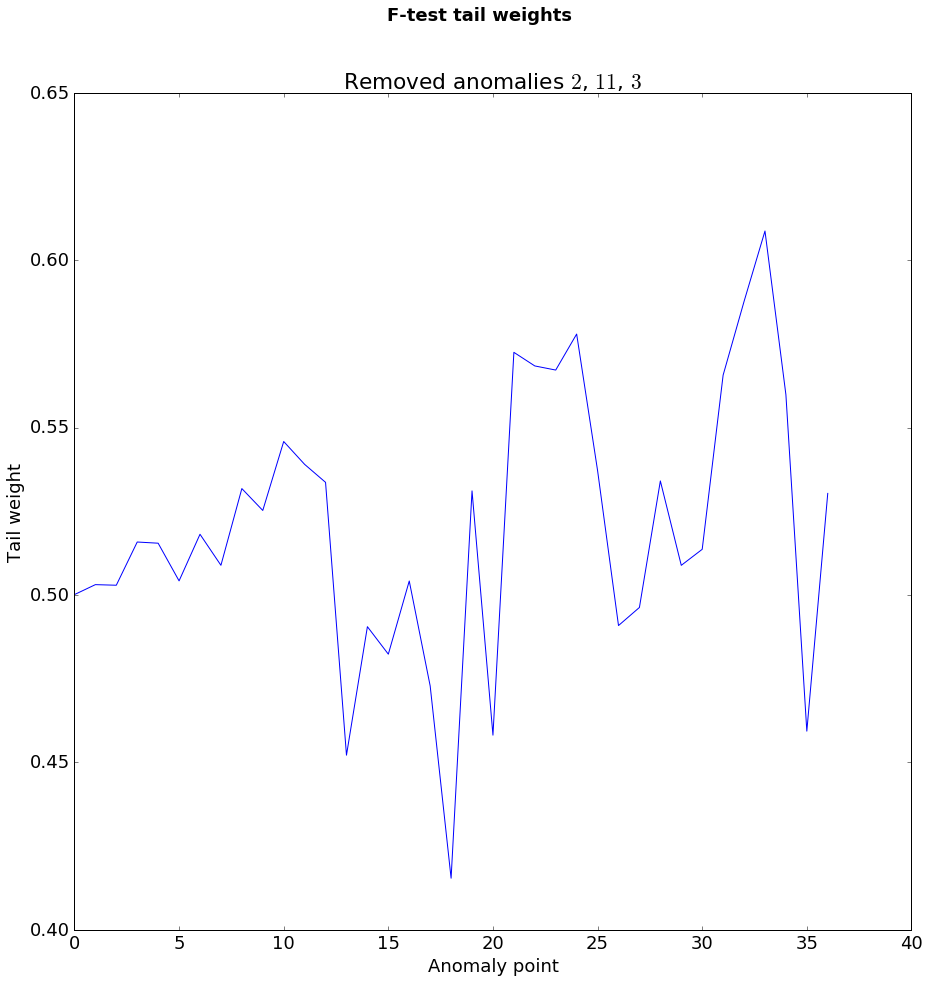

In [16]:
anomaly_points = []
while min_f_tail <= F_TAIL_CRITICAL:
    anomaly_points.append(suspicious_point)
    min_f_tail, suspicious_point = display_variances_without_anomalies(y, anomaly_points)

In [17]:
y_without_anomalies = y.copy()
t_without_anomalies = t[:-len(anomaly_points)]
for anomaly_point in anomaly_points:
    y_without_anomalies = delete(y_without_anomalies, anomaly_point)

## Without anomalies

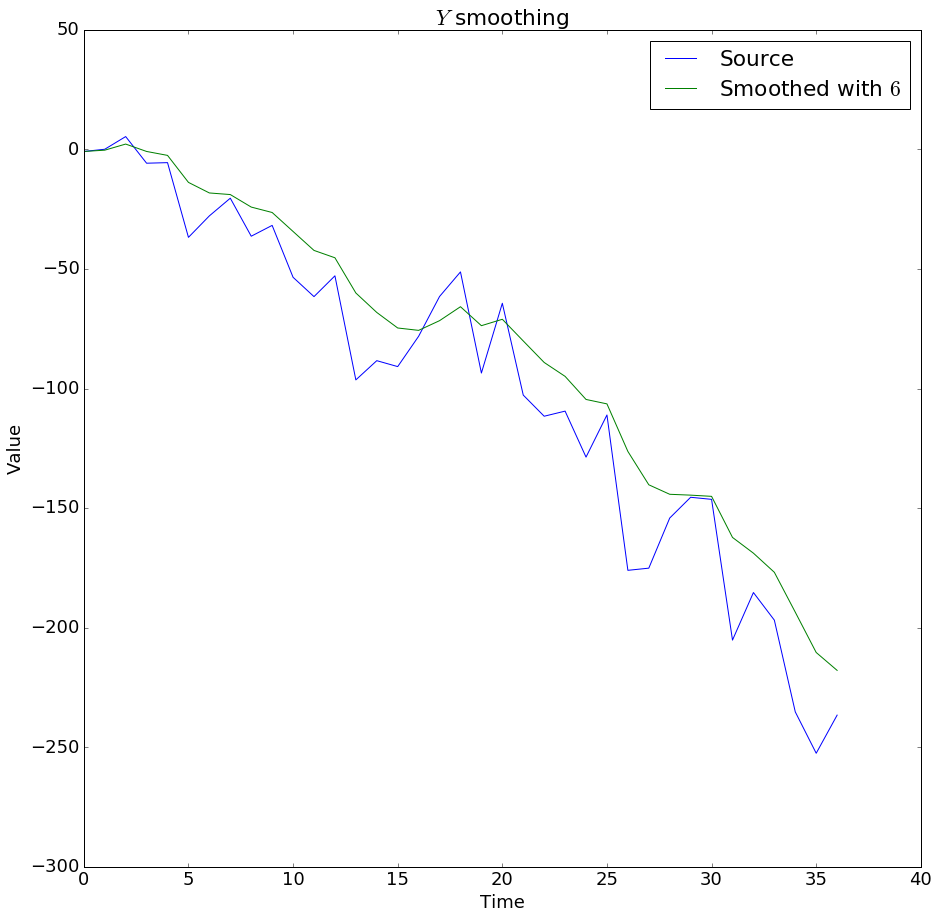

In [18]:
smoothed_y_without_anomalies = data_smoother(y_without_anomalies, span=span)

plt.plot(t_without_anomalies, y_without_anomalies, label='Source')
plt.plot(t_without_anomalies, smoothed_y_without_anomalies, label='Smoothed with $%d$'%span)

plt.title('$Y$ smoothing')
plt.ylabel('Value')
plt.xlabel('Time')

plt.legend()

plt.show()

## Choose proper span

We need to find proper span for exponentially-weighted moving average in order to have further calculations right

We know only that distribution of the noise is normal, so we can use
[normality test](https://en.wikipedia.org/wiki/D%27Agostino%27s_K-squared_test) of Ralph D'Agostino
and choose the span with which errors have the biggest normality

In [19]:
def get_smoothing_errors_normality(data, span):
    return normaltest(data - data_smoother(data, span=span))

In [20]:
def get_best_span(data, min_span=2, max_span=10):
    return (min_span
        + array([get_smoothing_errors_normality(y_without_anomalies, s).statistic
                 for s in range(min_span, max_span + 1)]).argmin())

In [21]:
best_span = get_best_span(y_without_anomalies)

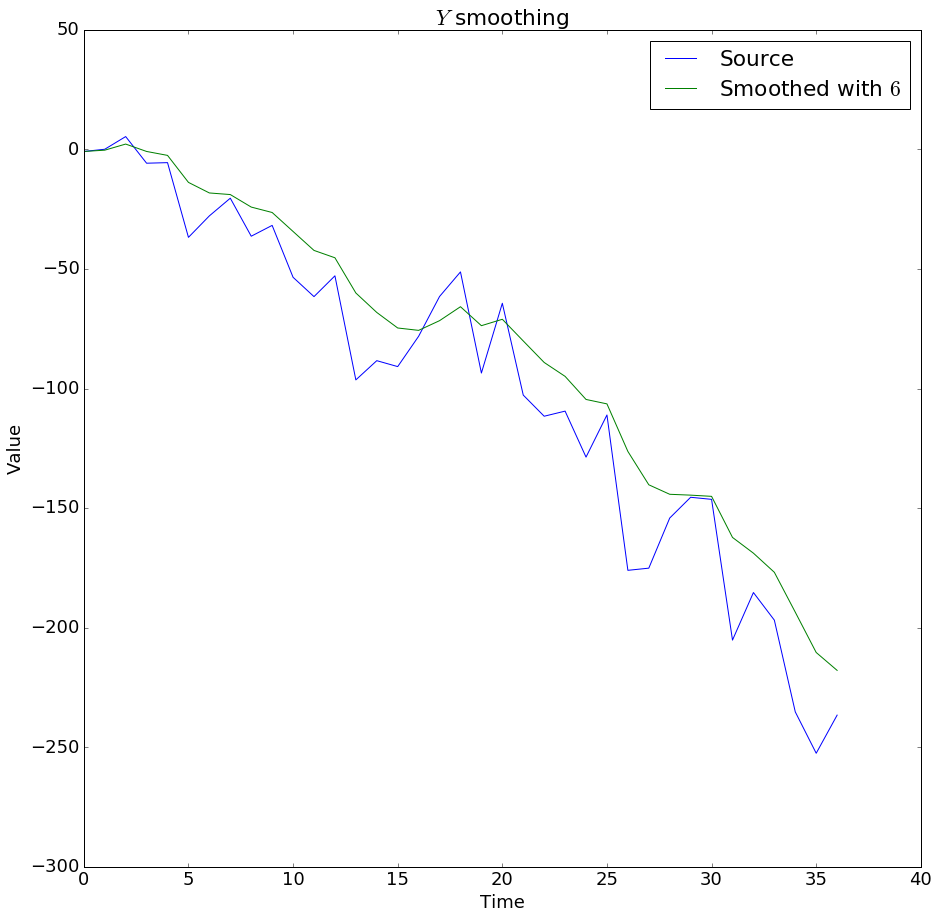

In [22]:
smoothed_y_without_anomalies = data_smoother(y_without_anomalies, span=best_span)
errors = y_without_anomalies - smoothed_y_without_anomalies

plt.plot(t_without_anomalies, y_without_anomalies, label='Source')
plt.plot(t_without_anomalies, smoothed_y_without_anomalies, label='Smoothed with $%d$'%best_span)

plt.title('$Y$ smoothing')
plt.ylabel('Value')
plt.xlabel('Time')

plt.legend()

plt.show()

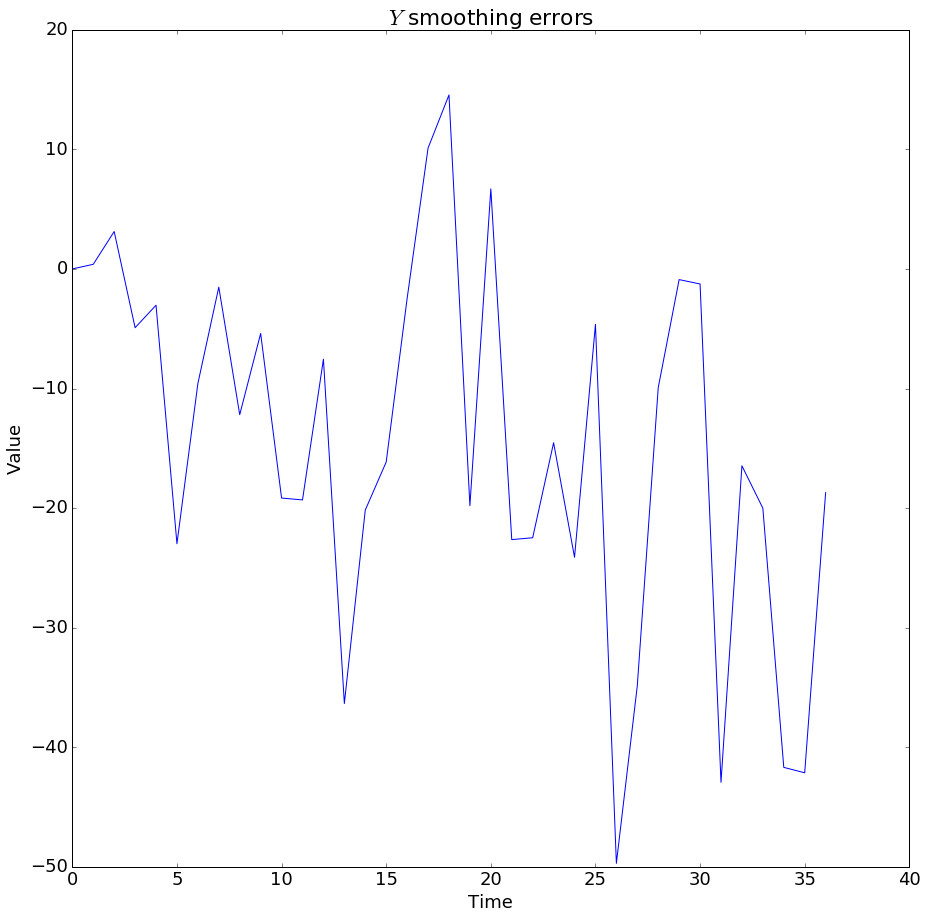

In [23]:
plt.plot(t_without_anomalies, errors)

plt.title('$Y$ smoothing errors')
plt.ylabel('Value')
plt.xlabel('Time')

plt.show()

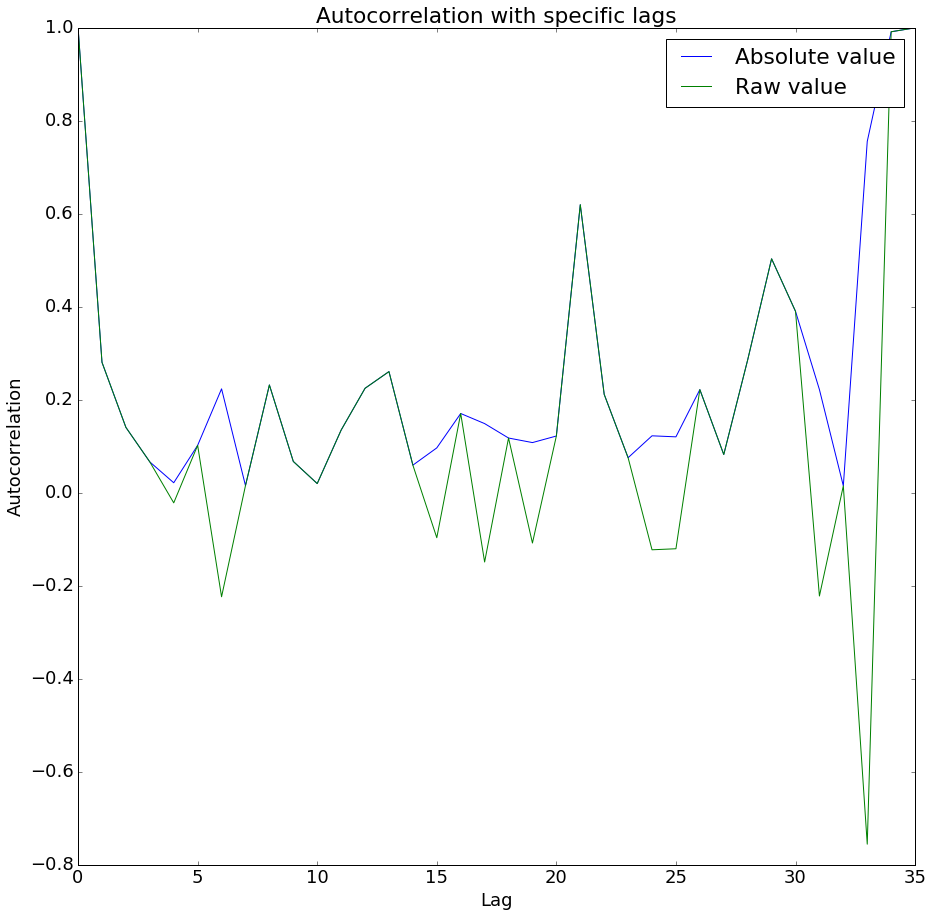

In [24]:
max_lag = errors.size - 1

autocorrelation = array([Series(errors).autocorr(i) for i in range(max_lag)])

plt.plot(list(range(max_lag)), abs(autocorrelation), label='Absolute value')
plt.plot(list(range(max_lag)), autocorrelation, label='Raw value')

plt.title('Autocorrelation with specific lags')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()

plt.show()